# Differentiable Simulation of Detailed Neuron Morphologies
Author: Christian Pehle


In [1]:
import jax.numpy as np
import tree_math
import dataclasses

from njx.base import funcutils
from njx.base import implicit
from njx.base.tree_solver import tree_solve, tree_matmul
from njx.base.types import ArrayLike

import njx.morph.generate_morphologies as gm
import matplotlib.pyplot as plt

In [2]:
@tree_math.struct
class HodgekinHuxleyState:
    v: ArrayLike
    m: ArrayLike
    h: ArrayLike
    n: ArrayLike

@tree_math.struct
class HodgekinHuxleyChannelState:
    m: ArrayLike
    h: ArrayLike
    n: ArrayLike


@tree_math.struct
class HodgekinHuxleyParameters:
    g_K: ArrayLike
    E_K: ArrayLike
    g_Na: ArrayLike
    E_Na: ArrayLike
    g_L: ArrayLike
    E_L: ArrayLike
    C_m_inv: ArrayLike

In [3]:
def channel_dynamics(alpha, beta):
    def dynamics(x: ArrayLike, v: ArrayLike):
        return alpha(v) * (1 - x) - beta(v) * x

    return dynamics

In [4]:
def alpha_n(Vm):
    return (0.02 * (Vm - 25.0)) / (1.0 - np.exp((-1.0 * (Vm - 25.0)) / 9.0))


def beta_n(Vm):
    return (-0.002 * (Vm - 25.0)) / (1.0 - np.exp((Vm - 25.0) / 9.0))


def alpha_m(Vm):
    return (0.182 * (Vm + 35.0)) / (1.0 - np.exp((-1.0 * (Vm + 35.0)) / 9.0))


def beta_m(Vm):
    return (-0.124 * (Vm + 35.0)) / (1.0 - np.exp((Vm + 35.0) / 9.0))


def alpha_h(Vm):
    return 0.25 * np.exp((-1.0 * (Vm + 90.0)) / 12.0)


def beta_h(Vm):
    return (0.25 * np.exp((Vm + 62.0) / 6.0)) / np.exp((Vm + 90.0) / 12.0)

In [5]:
def x0(alpha, beta):
    def x0(v):
        return alpha(v) / (alpha(v) + beta(v))

    return x0


h0 = x0(alpha_h, beta_h)
n0 = x0(alpha_n, beta_n)
m0 = x0(alpha_m, beta_m)

In [6]:
def I_Na(s: HodgekinHuxleyState, p: HodgekinHuxleyParameters):
    return p.g_Na * np.power(s.m, 3) * s.h * (s.v - p.E_Na)


def I_K(s: HodgekinHuxleyState, p: HodgekinHuxleyParameters):
    return p.g_K * np.power(s.n, 4) * (s.v - p.E_K)


def I_L(s: HodgekinHuxleyState, p: HodgekinHuxleyParameters):
    return p.g_L * (s.v - p.E_L)


def hodgekin_huxley_dynamics(p: HodgekinHuxleyParameters):
    m_dynamics = channel_dynamics(alpha_m, beta_m)
    h_dynamics = channel_dynamics(alpha_h, beta_h)
    n_dynamics = channel_dynamics(alpha_n, beta_n)

    def dynamics(s: HodgekinHuxleyState, I: ArrayLike):
        return HodgekinHuxleyState(
            v=-p.C_m_inv * (I_K(s, p) + I_Na(s, p) + I_L(s, p) - I),
            m=m_dynamics(s.m, s.v),
            n=n_dynamics(s.n, s.v),
            h=h_dynamics(s.h, s.v),
        )

    return dynamics

def hodgekin_huxley_channel_dynamics(p: HodgekinHuxleyParameters):
    m_dynamics = channel_dynamics(alpha_m, beta_m)
    h_dynamics = channel_dynamics(alpha_h, beta_h)
    n_dynamics = channel_dynamics(alpha_n, beta_n)

    def dynamics(s: HodgekinHuxleyChannelState, v: ArrayLike):
        return HodgekinHuxleyChannelState(
            m=m_dynamics(s.m, v),
            n=n_dynamics(s.n, v),
            h=h_dynamics(s.h, v),
        )

    return dynamics

def hodgekin_huxley_current(s: HodgekinHuxleyState, p : HodgekinHuxleyParameters):
    return I_K(s, p) + I_Na(s, p) + I_L(s, p)

In [7]:
def hodgekin_huxley_initial_state(v: ArrayLike):
    h0 = x0(alpha_h, beta_h)
    n0 = x0(alpha_n, beta_n)
    m0 = x0(alpha_m, beta_m)
    return HodgekinHuxleyChannelState(m=m0(v), h=h0(v), n=n0(v))

In [8]:
@tree_math.struct
class NeuronState:
    v: ArrayLike
    I: ArrayLike
    c: HodgekinHuxleyChannelState



@dataclasses.dataclass
class MultiCompartmentNeuronModel(implicit.ImplicitExplicitODE):
    d: ArrayLike
    u: ArrayLike
    p: ArrayLike
    h: HodgekinHuxleyParameters

    def explicit_terms(self, state):
        return NeuronState(
            v=state.I - hodgekin_huxley_current(HodgekinHuxleyState(v=state.v, m=state.c.m, n=state.c.n, h=state.c.h), self.h), 
            I=-20 * state.I, 
            c=hodgekin_huxley_channel_dynamics(self.h)(state.c, state.v)
        )

    def implicit_terms(self, state):
        return NeuronState(
            v=tree_matmul(self.d, self.u, self.p, state.v), 
            I=np.zeros_like(state.I),
            c=HodgekinHuxleyChannelState(m=np.zeros_like(state.I), n=np.zeros_like(state.I), h=np.zeros_like(state.I))
        )

    def implicit_solve(self, state, step_size):
        return NeuronState(
            v=tree_solve(1 - step_size * self.d, -step_size * self.u, self.p, state.v),
            I=state.I,
            c=state.c
        )

We are using arbor for loading .swc geometries

In [9]:
import arbor
import numpy as np

morph = arbor.load_swc_arbor(
    "../../data/morphologies/allen/Cux2-CreERT2_Ai14-211772.05.02.01_674408996_m.swc"
)
policy = arbor.cv_policy_every_segment()
# generate control volumes
decor = arbor.decor()
decor = decor.discretization(policy)
# define regions using standard SWC tags
labels = arbor.label_dict(
    {"soma": "(tag 1)", "axon": "(tag 2)", "dend": "(join (tag 3) (tag 4))"}
)
cell = arbor.cable_cell(morph, decor, labels)
cv_data = arbor.cv_data(cell)
ncv = cv_data.num_cv

num_segments = 0

for i in range(morph.num_branches):
   #  print(f"Branch {i} has {morph.branch_children(i)} children")
    print(i, morph.branch_children(i))
    num_segments += len(morph.branch_segments(i))

    for segment in morph.branch_segments(i):

        # calculate area of conical frustum
        prox = np.array((segment.prox.x, segment.prox.y, segment.prox.z))
        dist = np.array((segment.dist.x, segment.dist.y, segment.dist.z))
        h = np.linalg.norm(prox - dist)
        s = np.sqrt((segment.prox.radius - segment.dist.radius) ** 2 + h ** 2)
        area = (segment.prox.radius + segment.dist.radius) * s * np.pi

        
        2 * segment.prox.radius * segment.dist.radius * np.pi
        # print(segment.prox.x, segment.dist, segment.tag)

print(num_segments)

0 [1, 2]
1 []
2 []
3 [4, 11]
4 [5, 6]
5 []
6 [7, 8]
7 []
8 [9, 10]
9 []
10 []
11 [12, 37]
12 [13, 14]
13 []
14 [15, 34]
15 [16, 31]
16 [17, 20]
17 [18, 19]
18 []
19 []
20 [21, 22]
21 []
22 [23, 28]
23 [24, 25]
24 []
25 [26, 27]
26 []
27 []
28 [29, 30]
29 []
30 []
31 [32, 33]
32 []
33 []
34 [35, 36]
35 []
36 []
37 [38, 39]
38 []
39 []
40 [41, 44]
41 [42, 43]
42 []
43 []
44 [45, 52]
45 [46, 47]
46 []
47 [48, 49]
48 []
49 [50, 51]
50 []
51 []
52 []
53 [54, 55]
54 []
55 []
56 [57, 124]
57 [58, 81]
58 [59, 62]
59 [60, 61]
60 []
61 []
62 [63, 68]
63 [64, 67]
64 [65, 66]
65 []
66 []
67 []
68 [69, 70]
69 []
70 [71, 76]
71 [72, 75]
72 [73, 74]
73 []
74 []
75 []
76 [77, 80]
77 [78, 79]
78 []
79 []
80 []
81 [82, 115]
82 [83, 114]
83 [84, 97]
84 [85, 96]
85 [86, 95]
86 [87, 94]
87 [88, 89]
88 []
89 [90, 91]
90 []
91 [92, 93]
92 []
93 []
94 []
95 []
96 []
97 [98, 107]
98 [99, 100]
99 []
100 [101, 102]
101 []
102 [103, 104]
103 []
104 [105, 106]
105 []
106 []
107 [108, 113]
108 [109, 110]
109 []
110

In [10]:
from jax import config
config.update("jax_debug_nans", True)
config.update("jax_enable_x64", True)

In [11]:
import numpy as onp
import jax.numpy as np

morph = gm.swc_geometry(
    "../../data/morphologies/allen/Cux2-CreERT2_Ai14-211772.05.02.01_674408996_m.swc"
)
tm = gm.compute_tree_matrix(morph)


N = len(tm.d)
dt = 0.01
inner_steps = 1
outer_steps = 32*2048
time = dt * inner_steps * (1 + np.arange(outer_steps))

param = HodgekinHuxleyParameters(
    C_m_inv=1.0,  # Inverse Membrane capacitance per unit area (cm^2/uF)
    g_K=35.0,  # Average potassium channel conductance per unit area (mS/cm^2)
    g_Na=40.0,  # Average sodoum channel conductance per unit area (mS/cm^2)
    g_L=0.3,  # Average leak channel conductance per unit area (mS/cm^2)
    E_K=-77.0,  # Potassium potential (mV)
    E_Na=55.0,  # Sodium potential (mV)
    E_L=-65.0,  # Leak potential (mV)
)

equation = MultiCompartmentNeuronModel(d=tm.d, u=tm.u, p=tm.p, h=param)

semi_implicit_step = implicit.imex_rk_sil3(equation, dt)
integrator = funcutils.trajectory(
    funcutils.repeated(semi_implicit_step, inner_steps), outer_steps
)

initial_state = NeuronState(v=param.E_L*np.ones(N), I=np.zeros(N), c=hodgekin_huxley_initial_state(param.E_L*np.ones(N)))
_, actual = integrator(initial_state)

TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on traced array with shape float64[7430]
The error occurred while tracing the function <lambda> at /Users/pehle/dev/jaxsnn/njx/base/funcutils.py:85 for scan. This concrete value was not available in Python because it depends on the value of the argument x[<flat index 2>][<flat index 2>].
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

In [15]:
np.min(actual.v), np.max(actual.v), np.max(actual.v[-1]), np.min(actual.v[-1])


norm = np.max(actual.v) - np.min(actual.v)
min_v = np.nanmin(actual.v)
norm

NameError: name 'actual' is not defined

Array(20.73642941, dtype=float64)

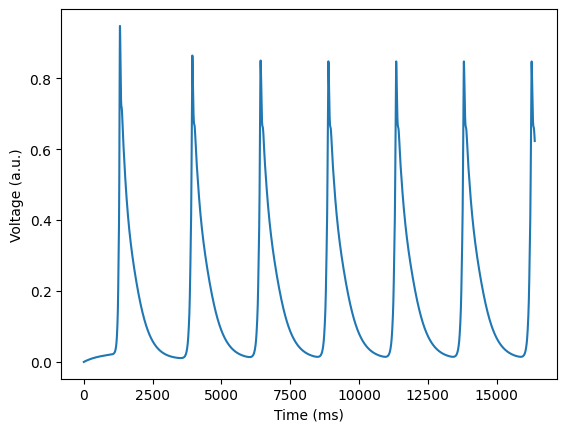

In [118]:
i = 70
plt.plot((actual.v[:,i] - min_v)/norm)
plt.ylabel("Voltage (a.u.)")
plt.xlabel("Time (ms)")
plt.savefig("example_trace_v.png", dpi=300)

np.nanmax(actual.v)

In [119]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


def plot_morphology(ax, morph, colors=None, colorscheme='Blues'):
    nb = morph.num_branches

    min_x = 0
    max_x = 1
    min_y = 0
    max_y = 1

    lines = []
    idx = 0
    cm = matplotlib.colormaps[colorscheme]

    indices = []

    for i in range(nb):
        segs = morph.branch_segments(i)
        xs = []
        ys = []

        for seg in segs:
            if colors is None:
                color = 'black'
            else:
                color = cm(colors[idx])
            xs.append(seg.prox.x)
            xs.append(seg.dist.x)
            ys.append(seg.prox.y)
            ys.append(seg.dist.y)
            idx = idx + 1


            lines.append(Line2D([seg.prox.x, seg.dist.x], [seg.prox.y, seg.dist.y], linewidth=1, color=color))

        min_x = min(min_x, min(xs))
        max_x = max(max_x, max(xs))
        min_y = min(min_y, min(ys))
        max_y = max(max_y, max(ys))

    for line in lines:
        ax.add_line(line)

    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)

In [120]:
actual.v.shape

(16384, 7430)

In [121]:
import matplotlib.animation as animation


def animate_dynamics(actual, morph, filename, n_frames=300, colorscheme='Blues'):
    fig, ax = plt.subplots(figsize=(10, 10))
    step = 0

    v = (actual.v[step] - min_v)/norm 
    ax.set_axis_off()
    plot_morphology(ax, morph, colors=onp.array(v))
    fig.tight_layout()

    def update(step):
        ax.clear()
        ax.set_axis_off()
        v = (actual.v[10*step] - min_v)/norm 
        plot_morphology(ax, morph, colors=onp.array(v), colorscheme=colorscheme)
        fig.tight_layout()
        return ax

    ani = animation.FuncAnimation(
        fig, update, frames=np.arange(0, n_frames, 1), interval=100
    )
    ani.save(filename, writer="ffmpeg", fps=60)

[0.00000000e+00 1.34589502e-04 2.69179004e-04 ... 9.99596231e-01
 9.99730821e-01 9.99865410e-01]


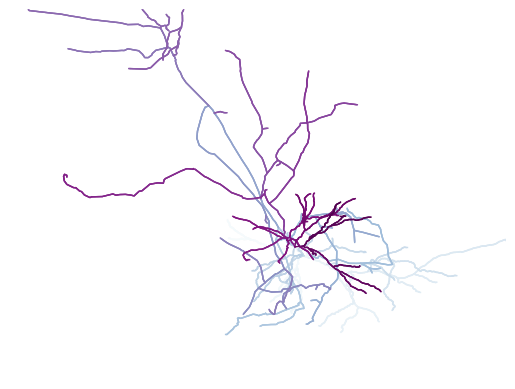

In [122]:
ax = plt.gca()
ax.set_axis_off()

colors = np.arange(0,actual.v.shape[1])/actual.v.shape[1]
print(colors)
plot_morphology(ax, morph, colors=colors, colorscheme='BuPu')
plt.savefig("example_morphology.png", dpi=300)

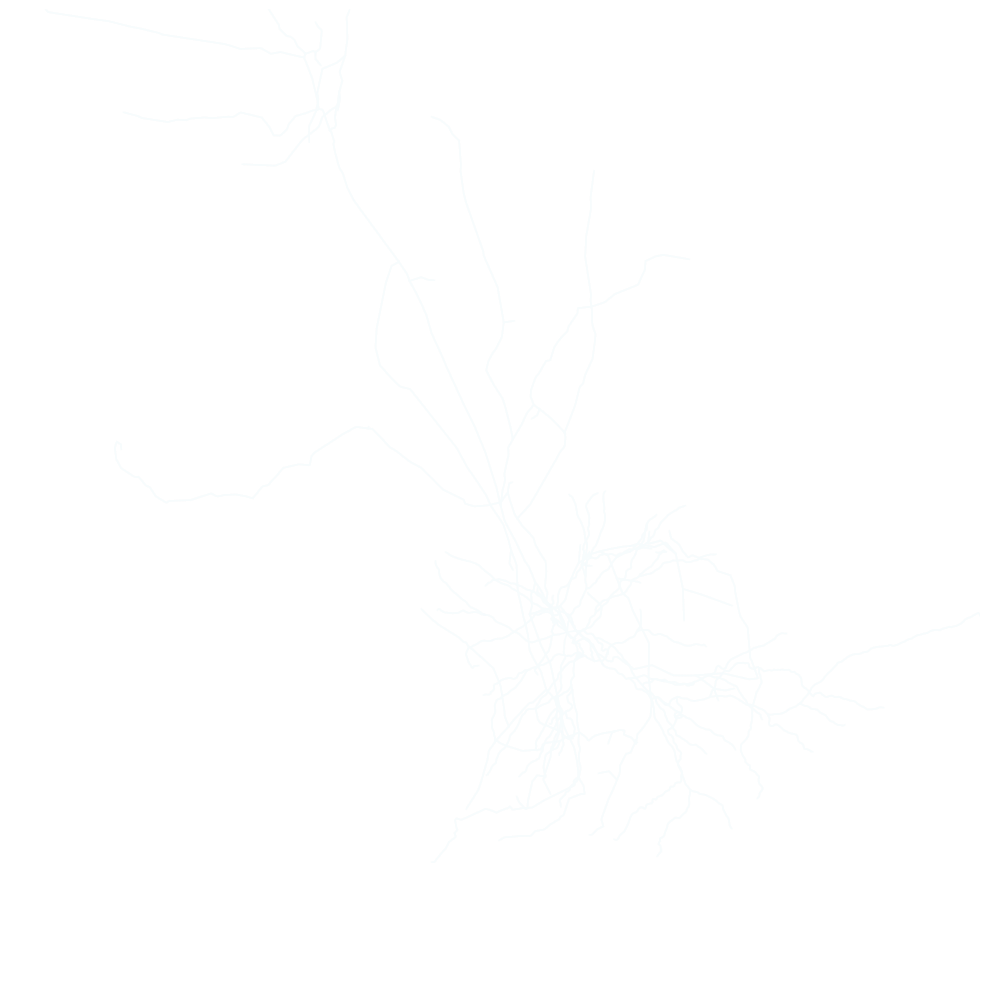

In [125]:
animate_dynamics(actual, morph, filename="test_2.mp4", n_frames=actual.v.shape[0]//10, colorscheme='BuPu')